### moduleのimport

In [2]:
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pydicom
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 0.関数

### 0.1.dicomのパスからimageにする関数を作成

In [49]:
def dcm_to_image(path):
    d = pydicom.read_file(path)
    image = d.pixel_array
    return image

### 0.2.dirから画像一枚を選び、パスを返す

In [ ]:
def dir_path_to_good_image_array(dirpath):
    good_image_path = 0
    num_sum = 0
    for f in glob.glob(dirpath + '*.dcm'):
        d = pydicom.read_file(f)
        data = d.pixel_array
        if num_sum <= np.sum(data):
            num_sum = np.sum(data)
            good_image_path = f

#     print(good_image_path)
#     g = pydicom.read_file(good_image_path)
#     good_image_array = g.pixel_array
    return good_image_path

In [38]:
def dir_path_to_good_image_path_2(dir_path):
    num_list = []
    for f in glob.glob(dir_path + '*.dcm'):
        num = f.split('/')[-1].split('-')[1].split('.')[0]
        num_list.append(int(num))
        good_image_num = sorted(num_list)[len(num_list) // 2]
    good_path = dir_path + 'Image-' + str(good_image_num) + '.dcm'
    return good_path

print(dir_path_to_good_image_path_2('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/'))

../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-201.dcm


### 0.3.画像を192 * 192のサイズに変更

In [39]:
def convert_to_192by192_image(image):
    center = [0, 0]
    center[0] = image.shape[0] // 2
    center[1] = image.shape[1] // 2
    image = image[center[0] - 96 : center[0] + 96, center[1] - 96 : center[1] + 96]
    return image

### pathを何度も書くのが面倒なのでroot_pathを設定

In [40]:
root_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/'

### csvデータをもとにdataframeに

In [41]:
train = pd.read_csv(root_path + 'train_labels.csv')
test = pd.read_csv(root_path + 'sample_submission.csv')
submission = pd.read_csv(root_path + 'sample_submission.csv')

In [42]:
print('===========================')
print('train.head() is below')
print('                           ')
print(train.head())
print('                           ')
print('===========================')
print('test.head() is below')
print('                           ')
print(test.head())
print('                           ')
print('===========================')
print('submission.head() is below')
print('                           ')
print(submission.head())
print('                           ')
print('===========================')

train.head() is below
                           
   BraTS21ID  MGMT_value
0          0           1
1          2           1
2          3           0
3          5           1
4          6           1
                           
test.head() is below
                           
   BraTS21ID  MGMT_value
0          1         0.5
1         13         0.5
2         15         0.5
3         27         0.5
4         37         0.5
                           
submission.head() is below
                           
   BraTS21ID  MGMT_value
0          1         0.5
1         13         0.5
2         15         0.5
3         27         0.5
4         37         0.5
                           


## 1.画像の準備

### 1.2.複数画像での分析のやり方がわからないのでとりあえずFLAIRのgood画像だけで分析してみるので前処理としてIDを変更

In [43]:
train = pd.read_csv(root_path + 'train_labels.csv')
train["BraTS21ID"] = train["BraTS21ID"].apply(lambda x: str(x).zfill(5))

test = pd.read_csv(root_path + 'sample_submission.csv')
test["BraTS21ID"] = test["BraTS21ID"].apply(lambda x: str(x).zfill(5))

### 1.3.データフレームに分析用のデータ(path)を入れていく

In [44]:
train['FLAIR'] = 0
a=0
for i in tqdm(train['BraTS21ID']):
    dir_path ='../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{}/FLAIR/'.format(i)
    train['FLAIR'][a] = dir_path_to_good_image_path_2(dir_path)
#     dir_path ='../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{}/T1w/'.format(i)
#     train['T1w'][a] = dir_path_to_good_image_array(dir_path)
#     dir_path ='../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{}/T1wCE/'.format(i)
#     train['T1wCE'][a] = dir_path_to_good_image_array(dir_path)
#     dir_path ='../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{}/T2w/'.format(i)
#     train['T2w'][a] = dir_path_to_good_image_array(dir_path)
    a+=1

100%|██████████| 585/585 [00:10<00:00, 58.30it/s] 


### 1.4.テストにも入れていく

In [45]:
test['FLAIR'] = 0
a = 0
for i in tqdm(test['BraTS21ID']):
    dir_path ='../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/{}/FLAIR/'.format(i)
    test['FLAIR'][a] = dir_path_to_good_image_path_2(dir_path)
#     dir_path ='../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/{}/T1w/'.format(i)
#     test['T1w'][a] = dir_path_to_good_image_array(dir_path)
#     dir_path ='../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/{}/T1wCE/'.format(i)
#     test['T1wCE'][a] = dir_path_to_good_image_array(dir_path)
#     dir_path ='../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/{}/T2w/'.format(i)
#     test['T2w'][a] = dir_path_to_good_image_array(dir_path)
    a+=1

100%|██████████| 87/87 [00:03<00:00, 28.96it/s]


### 1.5.それぞれの形を軽く見てみる

In [46]:
print('===========================')
print('train.head() is below\n')
print(train.head())
print('===========================')
print('test.head() is below\n')
print(test.head())
print('===========================')
print('submission.head() is below\n')
print(submission.head())
print('===========================')

train.head() is below

  BraTS21ID  MGMT_value                                              FLAIR
0     00000           1  ../input/rsna-miccai-brain-tumor-radiogenomic-...
1     00002           1  ../input/rsna-miccai-brain-tumor-radiogenomic-...
2     00003           0  ../input/rsna-miccai-brain-tumor-radiogenomic-...
3     00005           1  ../input/rsna-miccai-brain-tumor-radiogenomic-...
4     00006           1  ../input/rsna-miccai-brain-tumor-radiogenomic-...
test.head() is below

  BraTS21ID  MGMT_value                                              FLAIR
0     00001         0.5  ../input/rsna-miccai-brain-tumor-radiogenomic-...
1     00013         0.5  ../input/rsna-miccai-brain-tumor-radiogenomic-...
2     00015         0.5  ../input/rsna-miccai-brain-tumor-radiogenomic-...
3     00027         0.5  ../input/rsna-miccai-brain-tumor-radiogenomic-...
4     00037         0.5  ../input/rsna-miccai-brain-tumor-radiogenomic-...
submission.head() is below

   BraTS21ID  MGMT_value
0 

### 192 * 192への画像リサイズの関数を作成

In [47]:
def convert_to_192by192_image(image):
    center = [0, 0]
    center[0] = image.shape[0] // 2
    center[1] = image.shape[1] // 2
    image = image[center[0] - 96 : center[0] + 96, center[1] - 96 : center[1] + 96]
    return image

### 1.6. 訓練用のデータセットに整形したデータを入れていく

In [50]:
X_train = []
y_train = []
X_test = []
y_test = []
for i in tqdm(range(len(train))):
    image = dcm_to_image(train['FLAIR'][i])
    image = convert_to_192by192_image(image)
    X_train.append(image)
    y_train.append(train['MGMT_value'][i])

for i in tqdm(range(len(test))):
    image = dcm_to_image(test['FLAIR'][i])
    image = convert_to_192by192_image(image)
    X_test.append(image)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 87/87 [00:01<00:00, 86.77it/s]


## 2.ニューラルネットワークの構築

In [51]:
import tensorflow as tf

In [61]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (192, 192)),
    tf.keras.layers.Dense(10000, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation = "softmax"),
])

## モデルの学習

In [62]:
model1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

Epoch 1/20
19/19 [==============================] - 27s 1s/step - loss: 69797.3025 - accuracy: 0.4538
Epoch 2/20
19/19 [==============================] - 27s 1s/step - loss: 13779.4255 - accuracy: 0.5114
Epoch 3/20
19/19 [==============================] - 27s 1s/step - loss: 5174.9585 - accuracy: 0.5298
Epoch 4/20
19/19 [==============================] - 28s 1s/step - loss: 1831.8202 - accuracy: 0.5313
Epoch 5/20
19/19 [==============================] - 27s 1s/step - loss: 1248.1919 - accuracy: 0.4732
Epoch 6/20
19/19 [==============================] - 27s 1s/step - loss: 1079.4185 - accuracy: 0.5009
Epoch 7/20
19/19 [==============================] - 28s 1s/step - loss: 1128.3954 - accuracy: 0.5370
Epoch 8/20
19/19 [==============================] - 28s 1s/step - loss: 551.7318 - accuracy: 0.5405
Epoch 9/20
19/19 [==============================] - 28s 1s/step - loss: 516.4415 - accuracy: 0.5160
Epoch 10/20
19/19 [==============================] - 27s 1s/step - loss: 411.5167 - accurac

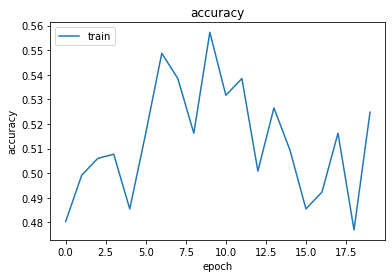

In [63]:
"""訓練の過程を表示する"""

history = model1.fit(X_train, y_train, epochs=20)
plt.plot(history.history['accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## モデルの評価

In [64]:
y_pred = model1.predict(X_test)
print(y_pred)

[[5.7003269e-09 1.0000000e+00]
 [1.0000000e+00 6.3293984e-34]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [9.9966300e-01 3.3698077e-04]
 [1.0000000e+00 4.1689509e-25]
 [4.4559148e-37 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 7.0013884e-10]
 [1.0000000e+00 1.0959259e-28]
 [1.0000000e+00 2.6631170e-20]
 [1.0000000e+00 4.6902086e-11]
 [1.0000000e+00 2.5106805e-25]
 [9.9999893e-01 1.0359748e-06]
 [9.7673833e-01 2.3261679e-02]
 [1.0000000e+00 3.7968396e-12]
 [1.0000000e+00 7.5510937e-26]
 [1.0000000e+00 3.5626786e-13]
 [1.0000000e+00 1.8327525e-09]
 [1.0000000e+00 1.8566214e-09]
 [9.9999905e-01 9.6345661e-07]
 [1.0000000e+00 3.4251115e-12]
 [1.0000000e+00 1.7651480e-13]
 [1.0000000e+00 5.5831012e-10]
 [1.0000000e+00 5.0474867e-12]
 [1.0000000e+00 1.7069695e-11]
 [9.9998796e-01 1.2026519e-05]
 [1.0000000e+00 4.7946152e-15]
 [9.9863273e-01 1.3672444e-03]
 [9.9999988e-01 8.3172175e-08]
 [1.0000

In [65]:
for i in range(len(y_pred)):
    submission['MGMT_value'][i] = y_pred[i].argmax()

In [66]:
submission.head()

,BraTS21ID,MGMT_value
0,1,1.0
1,13,0.0
2,15,0.0
3,27,0.0
4,37,1.0


In [ ]:
# submission.to_csv('submission.csv', index = False)

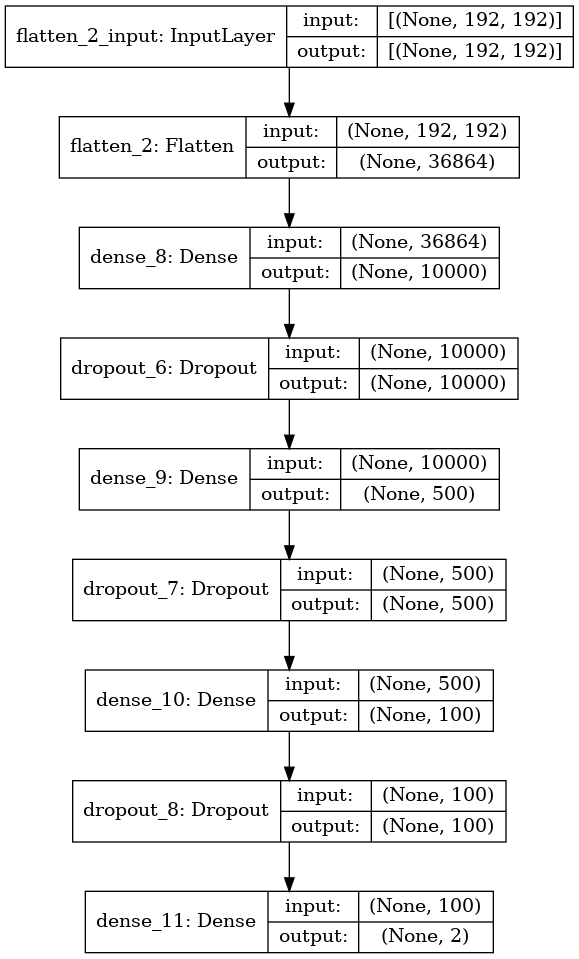

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(
    model1,
    show_shapes=True,
)